In [1]:
import os
import sys
import json
import random
from itertools import product
from collections import Counter
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind
import numpy as np
from numpy.linalg import norm
from numpy import sqrt
from sklearn.metrics import accuracy_score
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from math import pi
import pickle
import matplotlib.pyplot as plt
from packages import data_container
from packages.data_container import Data
from packages.helper import play_trajs, rotate, sp2a, v2sp, psi, beta, d_theta, d_psi, sp2v, dist, min_dist, \
    vector_angle, signed_angle, side, inner, theta, min_sep, traj_speed
from packages.ode_simulator import ODESimulator
from parameters import approaches, avoidances
# For pickle to load the Data object, which is defined in packages.data_container
sys.modules['data_container'] = data_container

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Fajen_steer1a_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst2_data.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

# file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Bai_movObst1_data_30Hz.pickle'))
# with open(file, 'rb') as f:
#     data = pickle.load(f)

file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst1_data.pickle'))
with open(file, 'rb') as f:
    data = pickle.load(f)

    
%matplotlib qt

In [64]:
'''Multidimensional Scaling'''
model = 'cohen_avoid'
subjects = [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13]
X = []
for s in subjects:
    X.append(list(avoidances['Bai_movObst1'][model]['differential_evolution'][s].values())[1:])
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X)
plt.scatter(X_transformed[:,0], X_transformed[:,1], label=model)
for i, txt in enumerate(subjects):
    plt.annotate(str(txt), X_transformed[i])
plt.title("Parameters of 4 models fitted to individuals")
plt.xlabel('embedding dimension 1')
plt.ylabel('embedding dimension 2')
plt.gca().set_aspect('equal')
plt.legend()

In [65]:
'''PCA'''
model = 'cohen_avoid'
subjects = [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13]
X = []
for s in subjects:
    X.append(list(avoidances['Bai_movObst1'][model]['differential_evolution'][s].values())[1:])
pca = PCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)
print(avoidances['Bai_movObst1'][model]['differential_evolution'][s].keys())
print(pca.components_)
print(pca.explained_variance_ratio_)
plt.scatter(X_transformed[:,0], X_transformed[:,1], label=model)
for i, txt in enumerate(subjects):
    plt.annotate(str(txt), X_transformed[i])

dict_keys(['name', 'b1', 'k1', 'c5', 'c6', 'b2', 'k2', 'c7', 'c8'])
[[-6.35451430e-04 -2.28700642e-02  3.23448330e-03 -3.99363424e-04
   7.72505650e-03  9.99632255e-01 -7.45005729e-03  9.27953963e-03]
 [-8.75145750e-03 -9.99499550e-01  1.54447799e-02  5.34424177e-05
  -1.26364444e-02 -2.28130767e-02  2.26004446e-03  5.41779864e-04]]
[0.89108092 0.10727403]


In [93]:
cnt = 0
total = 0
headon = 0
for i in range(len(data.trajs)):
    if data.info['obst_speed'][i] == 0:
        continue
    total += 1
    if abs(data.info['obst_angle'][i]) == 180:
        headon += 1
    if i not in data.dump:
        cnt += 1
    else:
        print(data.dump[i])
print(total, cnt, headon, cnt - headon)

min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
1800 1782 360 1422


In [47]:
set(data.info['obst_speed'])

{0.0, 0.9, 1.0, 1.1, 1.2, 1.3}

### Cohen_movObst1

In [4]:
'''Animate data'''
############
subject = 3
trial = 111
############
%matplotlib qt
i = subject * 160 + trial - 1
i = 616
# p_obst = np.array(data.info['p_obst'][i])
t0 = data.info['obst_onset'][i]
t1 = data.info['obst_out'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)


In [9]:
'''Average traj by condition'''
'''
In within subject design, the standard error is within subject sum of squares (s_w) divided by root(2n(m-1))
n is the number of subjects m is number of conditions.
Confidence interval is +-z*SE, for 95% CI z = 1.96
'''
# # Index all conditions start from 0
# ic = {}
# i = 0
# for key in product(set(np.abs(data.info['obst_angle'])), set(data.info['obst_speed'])):
#     ic[key] = i
#     i += 1
# # Create data set for plotting
# subjs = {}
# for i in range(len(data.trajs)):
#     subj_id = data.info['subj_id'][i]
#     traj = data.info['p_subj'][i]
#     angle = abs(data.info['obst_angle'][i])
#     speed = data.info['obst_speed'][i]
#     if subj_id not in subjs:
#         subjs[subj_id] = {}
#     if (angle, speed) not in subjs[subj_id]:
#         subjs[subj_id][(angle, speed)] = []
#     subjs[subj_id][(angle, speed)].append(traj)
    
for angle in set(np.abs(data.info['obst_angle'])):
    for speed in set(data.info['obst_speed']):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_title(f'obst_angle {angle}, obst_speed {speed}')
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_aspect('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-0.5, 8.5)
        front = []
        behind = []
        len_front = float('inf')
        len_behind = float('inf')
        # Plot trials
        for i in range(len(data.trajs)):
            if angle != abs(data.info['obst_angle'][i]) or speed != data.info['obst_speed'][i] or i in data.dump:
                continue
            traj = data.info['p_subj'][i][:]
            order = data.info['pass_order'][i]
            if data.info['obst_angle'][i] < 0:
                traj[:, 0] *= -1
                
            ax.plot(traj[:, 0], traj[:, 1], color='k', linewidth=0.1, alpha=0.5)
            m = len(traj) // 2
            if order == 1:
                front.append(traj)
                len_front = min(len(traj), len_front)
            elif order == -1:
                behind.append(traj)
                len_behind = min(len(traj), len_behind)
        # Plot average trials
        front = [traj[:len_front] for traj in front]
        behind = [traj[:len_behind] for traj in behind]
        front = np.mean(front, axis=0)
        behind = np.mean(behind, axis=0)
        ax.plot(front[:, 0], front[:, 1], color='k')
        ax.plot(behind[:, 0], behind[:, 1], color='k')

In [28]:
data.info.keys()

dict_keys(['p_goal', 'p_obst', 'obst_angle', 'obst_speed', 'subj_id', 'trial_id', 'obst_onset', 'obst_out', 'w_goal', 'w_obst', 'order', 'ps_trial', 'ps_subj', 'time_stamp', 'pass_order', 'p_subj', 'v_subj', 'a_subj', 'v_obst', 'rel_dpsi'])

In [7]:
'''Speed control vs heading control all trials'''
%matplotlib qt
sc = []
hc = []
for i in range(len(data.trajs)):
    if i in data.dump: continue
    t0 = data.info['obst_onset'][i]
    t1 = data.info['obst_out'][i]
    v = data.info['v_subj'][i][t0:t1]
    a = data.info['a_subj'][i][t0:t1]
    speed_ctrl = np.array([np.inner(x, y)/norm(y) for x, y in zip(a, v)]) # a along direction of v
    heading_ctrl = np.sqrt(norm(a, axis=1) ** 2 - speed_ctrl ** 2) # a perpendicular to v
    sc.extend(speed_ctrl)
    hc.extend(heading_ctrl)
    plt.plot(speed_ctrl, color='r', linewidth=0.1, alpha=0.5)
    plt.plot(heading_ctrl, color='b', linewidth=0.1, alpha=0.5)
plt.title(f'mean speed control {np.mean(sc):.2f} mean heading control {np.mean(hc):.2f} ratio {np.mean(sc) / np.mean(hc): .2f}')

Text(0.5, 1.0, 'mean speed control 0.07 mean heading control 0.22 ratio  0.32')

In [8]:
set(data.info['obst_speed'])

{0.4, 0.6, 0.8}

In [ ]:
'''Speed control vs heading control by conditions'''
%matplotlib qt
for angle in set(np.abs(data.info['obst_angle'])):
    for speed in set(data.info['obst_speed']):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.set_title(f'obst_angle {angle}, obst_speed {speed}')
        ax.set_ylabel('acceleration (m/s**2)')
        ax.set_xlabel('time (s)')
        ax.set_xlim(-0.3, 4.5)
        ax.set_ylim(-0.1, 1.5)
        sc = []
        hc = []
        for i in range(len(data.trajs)):
            if angle != abs(data.info['obst_angle'][i]) or speed != data.info['obst_speed'][i] or i in data.dump:
                continue
            t0 = data.info['obst_onset'][i]
            t1 = data.info['obst_out'][i]
            v = data.info['v_subj'][i][t0:t1]
            a = data.info['a_subj'][i][t0:t1]
            speed_ctrl = np.abs([np.inner(x, y)/norm(y) for x, y in zip(a, v)]) # a along direction of v
            heading_ctrl = np.sqrt(norm(a, axis=1) ** 2 - speed_ctrl ** 2) # a perpendicular to v
            sc.extend(speed_ctrl)
            hc.extend(heading_ctrl)
            plt.plot(np.linspace(0, len(speed_ctrl)/data.Hz, len(speed_ctrl)), speed_ctrl, color='r', linewidth=0.1, alpha=0.5)
            plt.plot(np.linspace(0, len(speed_ctrl)/data.Hz, len(speed_ctrl)), heading_ctrl, color='b', linewidth=0.1, alpha=0.5)
        ax.set_title(f'obst_angle {angle}, obst_speed {speed}, \n mean speed control {np.mean(sc):.2f} mean heading control {np.mean(hc):.2f} ratio {np.mean(sc) / np.mean(hc): .2f}')

In [74]:
'''Speed control vs heading control by subject'''
for s in set(data.info['subj_id']):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f'subject {s}')
    ax.set_xlabel('acceleration (m/s**2)')
    ax.set_ylabel('time (s)')
    ax.set_xlim(-0.3, 4.5)
    ax.set_ylim(-0.1, 1.5)
    for i in range(len(data.trajs)):
        if s != data.info['subj_id'][i] or i in data.dump:
            continue
        t0 = data.info['obst_onset'][i]
        t1 = data.info['obst_out'][i]
        v = data.info['v_subj'][i][t0:t1]
        a = data.info['a_subj'][i][t0:t1]
        speed_ctrl = np.abs([np.inner(x, y)/norm(y) for x, y in zip(a, v)]) # a along direction of v
        heading_ctrl = np.sqrt(norm(a, axis=1) ** 2 - speed_ctrl ** 2) # a perpendicular to v
        sc.extend(speed_ctrl)
        hc.extend(heading_ctrl)
        plt.plot(np.linspace(0, len(speed_ctrl)/data.Hz, len(speed_ctrl)), speed_ctrl, color='r', linewidth=0.1, alpha=0.5)
        plt.plot(np.linspace(0, len(speed_ctrl)/data.Hz, len(speed_ctrl)), heading_ctrl, color='b', linewidth=0.1, alpha=0.5)
    ax.set_title(f'subject {s}, \n mean speed control {np.mean(sc):.2f} mean heading control {np.mean(hc):.2f} ratio {np.mean(sc) / np.mean(hc): .2f}')

In [2]:
'''effective data length'''
%matplotlib qt
l = []
sim = ODESimulator(data=data, ref=[0,1])
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        t0 = data.info['threshold_onset'][i]
        t1 = data.info['obst_out'][i]
        if t0 and t1:
            l.append((t1 - t0) / data.Hz)
plt.hist(l, bins=40)
# plt.plot(l)

Loading finished


(array([ 2.,  1.,  6., 10.,  7., 13., 16., 26., 28., 22., 45., 55., 60.,
        53., 57., 73., 63., 63., 57., 37., 57., 56., 44., 43., 28., 23.,
        18., 10.,  6.,  7.,  4.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([1.23333333, 1.33      , 1.42666667, 1.52333333, 1.62      ,
        1.71666667, 1.81333333, 1.91      , 2.00666667, 2.10333333,
        2.2       , 2.29666667, 2.39333333, 2.49      , 2.58666667,
        2.68333333, 2.78      , 2.87666667, 2.97333333, 3.07      ,
        3.16666667, 3.26333333, 3.36      , 3.45666667, 3.55333333,
        3.65      , 3.74666667, 3.84333333, 3.94      , 4.03666667,
        4.13333333, 4.23      , 4.32666667, 4.42333333, 4.52      ,
        4.61666667, 4.71333333, 4.81      , 4.90666667, 5.00333333,
        5.1       ]),
 <a list of 40 Patch objects>)

### Cohen_movObst2

In [84]:
'''Plot speed'''
for i in range(len(data.trajs)):
    if data.info['obst_out'][i] and data.info['obst_onset'][i] and i not in data.dump:
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        v_subj = data.info['v_subj'][i]
        s_subj = norm(v_subj, axis=1)
        plt.plot(s_subj[t0:t1], linewidth=0.1, alpha=0.5)

In [83]:
'''Animate data'''
############
subject = 3
trial = 111
############
%matplotlib qt
i = subject * 160 + trial - 1
i = 40
# p_obst = np.array(data.info['p_obst'][i])
t0 = data.info['obst_onset'][i]
t1 = data.info['obst_out'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_dist: ' + str(data.info['obst_dist'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)


In [77]:
data.info.keys()

dict_keys(['p_goal', 'p_obst', 'obst_angle', 'obst_dist', 'obst_speed', 'subj_id', 'trial_id', 'obst_onset', 'obst_out', 'w_goal', 'w_obst', 'order', 'ps_trial', 'ps_subj', 'time_stamp', 'pass_order', 'p_subj', 'v_subj', 'a_subj', 'v_obst', 'rel_dpsi'])

### Bai_movObst1

In [ ]:
'''trial lookup'''
i = 167
t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
data.info['rel_dpsi'][167][t1+1]

In [ ]:
'''Counting trials'''
cnt = 0
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        cnt += 1
cnt

In [23]:
'''effective data length'''
%matplotlib qt
l = []
sim = ODESimulator(data=data, ref=[0,1])
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
#         t0 = data.info['obst_onset'][i]
#         t0 = data.info['decision_onset'][i]
        t0 = data.info['threshold_onset'][i]
        t1 = data.info['obst_out'][i]
        if t0 and t1:
            l.append((t1 - t0) / data.Hz)
#             if t1 - t0 < 2:
#                 print(i, t0, t1)
#                 order = []
#                 for t in range(t0, t1):
#                     xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, t)
#                     # When beta and dpsi has the same sign it means pass in front, otherwise it means pass from behind
#                     dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
#                     angle = sim.data.info['obst_angle'][i]
#                     order.append(-dpsi * np.sign(angle))
#                 plt.plot(order)
#                 break
plt.hist(l, bins=40)
# plt.plot(l)

Loading finished


(array([  2.,   7.,  19.,  29.,  44.,  97.,  83., 101., 180., 134., 137.,
        114.,  83.,  98.,  61.,  58.,  23.,  19.,  17.,  11.,   4.,  20.,
          7.,   2.,  11.,   8.,  11.,  10.,   1.,   1.,   5.,   5.,   2.,
          1.,   4.,   5.,   2.,   2.,   2.,   2.]),
 array([1.3       , 1.44583333, 1.59166667, 1.7375    , 1.88333333,
        2.02916667, 2.175     , 2.32083333, 2.46666667, 2.6125    ,
        2.75833333, 2.90416667, 3.05      , 3.19583333, 3.34166667,
        3.4875    , 3.63333333, 3.77916667, 3.925     , 4.07083333,
        4.21666667, 4.3625    , 4.50833333, 4.65416667, 4.8       ,
        4.94583333, 5.09166667, 5.2375    , 5.38333333, 5.52916667,
        5.675     , 5.82083333, 5.96666667, 6.1125    , 6.25833333,
        6.40416667, 6.55      , 6.69583333, 6.84166667, 6.9875    ,
        7.13333333]),
 <a list of 40 Patch objects>)

In [56]:
'''Animate avoidance data'''
############
subject = 3
trial = 111
############
%matplotlib qt
i = subject * 160 + trial - 1
i = 1
# p_obst = np.array(data.info['p_obst'][i])
td = data.info['decision_onset'][i]
t0 = data.info['obst_onset'][i]
t1 = data.info['obst_out'][i]
p_goal = data.info['p_goal'][i]
p_subj = data.info['p_subj'][i]
p_obst = data.info['p_obst'][i]
trajs = [p_goal, p_obst, p_subj]
ws = [data.info['w_goal'], data.info['w_obst'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' obst_angle: ' + str(data.info['obst_angle'][i]) + ' obst_speed: ' + str(data.info['obst_speed'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i], td, t1)
play_trajs(trajs, ws, data.Hz, title=title, save=False)


0 2 81 206


In [19]:
set(data.info['obst_speed'])

{0.0, 0.9, 1.0, 1.1, 1.2, 1.3}

### Bai_movObst1: dpsi and order of passing

In [105]:
'''Compute initial passing order (-dpsi * sign(obst_angle)) time series'''
%matplotlib qt
orders = {}
conditions = np.zeros((5, 8))
angle_ins = {-157.5: 0, -135: 1, -112.5: 2, -90: 3, 90: 4, 112.5: 5, 135: 6, 157.5: 7}
speed_ins = {0.9: 0, 1: 1, 1.1: 2, 1.2: 3, 1.3: 4}
for i in range(len(sim.data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] != 0 and abs(data.info['obst_angle'][i]) != 180:
        rel_dpsi = data.info['rel_dpsi'][i]
        subj = data.info['subj_id'][i]
        angle = data.info['obst_angle'][i]
        speed = data.info['obst_speed'][i]
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        if subj not in orders:
            orders[subj] = {'correct': [], 'incorrect': []}
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        if np.sign(rel_dpsi[t0]) == data.info['pass_order'][i]:
            orders[subj]['correct'].append(rel_dpsi)
        else:
            orders[subj]['incorrect'].append(rel_dpsi)
            conditions[speed_ins[speed], angle_ins[angle]] += 1

In [104]:
'''Plot conditions of incorrect trial'''
# Scatter plot
# x = []
# y = []
# z = []
# for angle in angle_ins.values():
#     for speed in speed_ins.values():
#         x.append(angle)
#         y.append(speed)
#         z.append(conditions[angle, speed])
#         for _ in range(int(conditions[angle, speed])):
#             plt.scatter(angle + random.uniform(-0.25, 0.25), speed + random.uniform(-0.25, 0.25))

# plt.xticks(range(-1, 9), [""] + list(angle_ins.keys()) + [""])
# plt.yticks(range(-1, 5), [""] + list(speed_ins.keys()) + [""])

# Heatmap
plt.imshow(conditions, cmap='plasma')
for i in range(conditions.shape[0]):
    for j in range(conditions.shape[1]):
        text = plt.text(j, i, str(conditions[i, j]),
                       ha="center", va="center", color="w")
plt.xticks(range(-1, 9), [""] + list(angle_ins.keys()) + [""])
plt.yticks(range(-1, 5), [""] + list(speed_ins.keys()) + [""])
plt.xlabel("angle")
plt.ylabel("speed")

# 3D bar graph
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.bar3d(x,y,0,0.5,0.5,z)
# ax.set_xticks(angle_ins.keys())
# ax.set_yticks(speed_ins.keys())

Text(0, 0.5, 'speed')

In [14]:
'''Check initial dpsi and subject passing choice, plot dpsi of matching and non-matching trials'''
%matplotlib qt
subjects = set(data.info['subj_id'])
print(subjects)
side_pred = []
side_true = []
dpsi_match = []
dpsi_not = []
for i in range(len(sim.data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] != 0 and abs(data.info['obst_angle'][i]) != 180:
        # When angle and dpsi has the opposite sign it means pass in front, otherwise it means pass from behind
        t0 = data.info['obst_onset'][i]
        rel_dpsi = data.info['rel_dpsi'][i][t0]
        side_pred.append(1 if rel_dpsi > 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if side_pred[-1] == side_true[-1]:
            dpsi_match.append(rel_dpsi)
        else:
            dpsi_not.append(rel_dpsi)
print('passing order matching rate ', accuracy_score(side_true, side_pred))
thres = 0.02
print(f'{np.mean(np.absolute(np.array(dpsi_not)) < thres) * 100}% mis-matching trials have an intial dpsi < {thres}')
plt.scatter(np.random.uniform(size=len(dpsi_match)), dpsi_match, label='matching trials')
plt.scatter(np.random.uniform(size=len(dpsi_not)), dpsi_not, label='mis-matching trials')
plt.ylabel('dpsi')
plt.xlabel('arbitrary')
plt.legend()


{0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13}
passing order matching rate  0.7447257383966245
97.52066115702479% mis-matching trials have an intial dpsi < 0.02


In [16]:
'''Correct order ratio'''
correct = incorrect = 0
for order in orders.values():
    correct += len(order['correct'])
    incorrect += len(order['incorrect'])
print(correct, incorrect, correct / (correct + incorrect))

1059 363 0.7447257383966245


In [7]:
'''Plot passing order (dpsi * sign(obst_angle)) time series'''
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        t0 = data.info['obst_onset'][i]
        t1 = data.info['obst_out'][i]
        rel_dpsi = data.info['rel_dpsi'][i]
        # Plot minimum |dpsi|
        mi = np.argmin(np.absolute(rel_dpsi[t0:t1]))
        plt.scatter(mi, rel_dpsi[mi + t0], c='k')
        # Plot maximum |dpsi| from time 0 to t_minimum|dpsi|
        ma = np.argmax(np.absolute(rel_dpsi[t0:t0 + mi + 1]))
        plt.scatter(ma, rel_dpsi[ma + t0], c='r')
        if np.sign(rel_dpsi[t0]) == data.info['pass_order'][i]:
            plt.plot(range(len(rel_dpsi[t0:t1])), rel_dpsi[t0:t1], linewidth=0.1, alpha=0.5, color='g')
        else:
            plt.plot(range(len(rel_dpsi[t0:t1])), rel_dpsi[t0:t1], linewidth=0.1, alpha=0.5, color='r')
plt.xlabel("Time since obst appear", fontsize=20)
plt.ylabel("dpsi (rad/s), positive means front", fontsize=20)

Text(0, 0.5, 'dpsi (rad/s), positive means front')

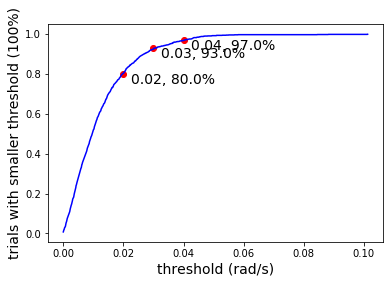

In [3]:
'''Plot x: threshold, y: % trials that have smaller threshold'''
thress = []
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['obst_speed'][i] > 0 and abs(data.info['obst_angle'][i]) != 180:
        t0 = data.info['obst_onset'][i]
        t1 = data.info['obst_out'][i]
        rel_dpsi = data.info['rel_dpsi'][i]
        # Find minimum |dpsi|
        mi = np.argmin(np.absolute(rel_dpsi[t0:t1]))
        # Find maximum |dpsi| from time 0 to t_minimum|dpsi|
        thres = max(np.absolute(rel_dpsi[t0:t0 + mi + 1]))
        thress.append(thres)
# evaluate the histogram
values, base = np.histogram(thress, bins=1000)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative / len(thress), c='blue')
plt.xlabel("threshold (rad/s)", fontsize=14)
plt.ylabel("trials with smaller threshold (100%)", fontsize=14)


# Mark point of interest
for v in [0.02, 0.03, 0.04]:
    x = np.argmin(np.absolute(base - v))
    y = round(cumulative[x] / len(thress), 2)
    x = round(base[x], 2)
    plt.scatter(x, y, c='r')
    plt.annotate(f"{x}, {round(y * 100, 2)}%", (x+0.0025, y-0.05), fontsize=14)

In [ ]:
'''Count pass order by condition'''
#########
angle = 157.5
speed = 1.1
#########
fpass = 0
total = 0
for i in range(len(data.trajs)):
    if abs(data.info['obst_angle'][i]) != angle or data.info['obst_speed'][i] != speed:
        continue
    if data.info['pass_order'][i] == 1:
        fpass += 1
    total += 1
print(fpass, total)
print(fpass / total)

In [ ]:
'''Plot dpsi dtheta by time'''
%matplotlib qt
subjects = range(16)
n = len(data.trajs)
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
fig2 = plt.figure()
ax2 = fig2.add_subplot()
for i in range(2,3):
    if (data.info['subj_id'][i] in subjects and
        i not in data.dump and
        data.info['obst_speed'][i] != 0 and
        abs(data.info['obst_angle'][i]) != 180):
        t0, t1 = data.info['obst_onset'][i], data.info['obst_out'][i]
        p0, p1 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1])
        v0, v1 = np.array(data.info['v_subj'][i][t0:t1]), np.array(data.info['v_obst'][i])
        a0 = np.array(data.info['a_subj'][i][t0:t1])
        a0 = norm(a0, axis=-1)
        v1 = np.tile(v1, (len(v0), 1))
        dpsis = np.absolute(d_psi(p0, p1, v0, v1))
        dthetas = d_theta(p0, p1, v0, v1, w=0.1)
        thetas = theta(p0, p1, w=0.1)
        ratio = dthetas/thetas
        ax0.plot(a0)
        c1, c2 = 0, 0.2
        ax1.plot((ratio+c1)/(dpsis+c2))
        ax2.scatter(ratio[60:80], a0[60:80], s=1)
#         ax2.scatter(range(len(dpsis)), dthetas/dpsis, s=1)

### Bai_movObst1: Minimum Passing Distance (MPD)

In [ ]:
'''Minimum Passing Distance'''
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title('Signed predicted minimum passing distance (SMPD)')
ax.set_ylabel('SMPD (m)')
ax.set_xlabel('normalized time (%)')
ax.set_ylim((-2, 2))
for i in range(len(data.trajs)):
    t0 = data.info['stimuli_onset'][i]
    t1 = data.info['stimuli_out'][i]
    p0 = data.info['p_subj'][i][t0:t1]
    p1 = data.info['p_obst'][i][t0:t1]
    v0 = data.info['v_subj'][i][t0:t1]
    v1 = data.info['v_obst'][i][t0:t1]
    t = np.linspace(0, 100, len(p0))
    smpd = []
    for _p0, _p1, _v0, _v1 in zip(p0, p1, v0, v1):        
        smpd.append(min_sep(_p0, _p1, _v0, _v1)[0])
    ax.plot(t, smpd, 'k', linewidth=0.1, alpha=0.5)
    
    

In [ ]:
'''Plot acceleration angle and magnitude'''
%matplotlib qt
trials = range(400,401)
subject = 1
con_angle = [90, -90]
con_speed = []
fig0 = plt.figure()
ax0 = fig0.add_subplot()
fig1 = plt.figure()
ax1 = fig1.add_subplot()
for i in trials:
    angle = data.info['obst_angle'][i]
    speed = data.info['obst_speed'][i]
    subj_id = data.info['subj_id'][i]
    if i in data.dump:
        continue
#     if angle not in con_angle or subj_id != subject:
#         continue
    t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
    p0, p1, a0 = np.array(data.info['p_subj'][i][t0:t1]), np.array(data.info['p_obst'][i][t0:t1]), np.array(data.info['a_subj'][i][t0:t1])
    angles = signed_angle(p1 - p0, a0)
    ax0.scatter(range(len(angles)), angles, s=1)
    ax1.plot(norm(a0, axis=-1))
    print(data.info['subj_id'][i], data.info['trial_id'][i])

### Bai_movObst1: Plot trajectories

In [ ]:
'''Plot data by condition'''
#####################
subject = 3
con_ang = [112.5]
con_spd = [1.1]
con_ipd = [0, 0.07]
# con_ang = set(data.info['obst_angle'])
# con_spd = set(data.info['obst_speed'])
#####################
%matplotlib qt
plt.figure()
n = 0
for i in range(len(data.trajs)):
    obst_speed = data.info['obst_speed'][i]
    obst_angle = data.info['obst_angle'][i]
    ipd = data.info['ipd'][i]
    subj_id = data.info['subj_id'][i]
    if subject != -1 and subj_id != subject:
        continue
    if not (obst_speed in con_spd and abs(obst_angle) in con_ang and ipd in con_ipd):
        continue
    subj = data.info['p_subj'][i]
    obst = np.array(data.info['p_obst'][i])
    n += 1
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if obst_angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    if ipd == 0:
        plt.plot(subj[:, 0], subj[:, 1], color='r')
    else:
        plt.plot(subj[:, 0], subj[:, 1], color='b')
    plt.plot(obst[:, 0], obst[:, 1])
ax = plt.gca()
# ax.set_aspect('equal')
ax.set_title('subj ' + str(subject) + ' angle: ' + str(con_ang[0]) + ' speed: ' + str(con_spd[0]))
print(n)

In [ ]:
'''Plot data by subject'''
#####################
subject = 13
#####################
%matplotlib qt
fig = plt.figure()
fig.suptitle('Subject ' + str(subject))
axes = {}
obst_angle = [90, 112.5, 135, 157.5, 180]
obst_speed = [0.9, 1.0, 1.1, 1.2, 1.3]
i_plot = 1
for angle in obst_angle:
    for speed in obst_speed:
        axes[(angle, speed)] = fig.add_subplot(5, 5, i_plot)
        axes[(angle, speed)].set_xlim(-3, 3)
        axes[(angle, speed)].set_ylim(-7, 5)
        axes[(angle, speed)].set_title(str(angle) + '° ' + str(speed) + 'm/s')
        axes[(angle, speed)].set_aspect('equal')
        i_plot += 1
for i in range(len(data.trajs)):
    speed = data.info['obst_speed'][i]
    angle = data.info['obst_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject or speed == 0:
        continue
    subj = np.array(data.info['p_subj'][i])
    obst = np.array(data.info['p_obst'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
    if angle < 0:
        subj[:, 0] *= -1
        obst[:, 0] *= -1
    axes[(abs(angle), speed)].plot(subj[:, 0], subj[:, 1])
    axes[(abs(angle), speed)].plot(obst[:, 0], obst[:, 1])

In [88]:
'''Plot obst trajectories'''
visited = set()
for i in range(len(data.trajs)):
    angle = data.info['obst_angle'][i]
    speed = data.info['obst_speed'][i]
    if speed != 0 and (angle, speed) not in visited:
        visited.add((angle, speed))
        obst = data.info['p_obst'][i]
        if data.trajs[i][0][0] > 0:
            obst = rotate(obst, np.arctan(11 / 9) + pi / 2)
        else:
            obst = rotate(obst, np.arctan(11 / 9) - pi / 2)
        plt.plot(obst[:data.Hz*10, 0], obst[:data.Hz*10, 1], 'k')
        plt.scatter(obst[0, 0], obst[0, 1], c='k', marker='x')
plt.scatter(0, -13.1, c='k', marker='o')
plt.annotate("Participant", (0, -12.1))
plt.gca().set_aspect('equal') 
plt.xlabel("x (m)")
plt.ylabel("y (m)")
visited

{(-180.0, 0.9),
 (-180.0, 1.0),
 (-180.0, 1.1),
 (-180.0, 1.2),
 (-180.0, 1.3),
 (-157.5, 0.9),
 (-157.5, 1.0),
 (-157.5, 1.1),
 (-157.5, 1.2),
 (-157.5, 1.3),
 (-135.0, 0.9),
 (-135.0, 1.0),
 (-135.0, 1.1),
 (-135.0, 1.2),
 (-135.0, 1.3),
 (-112.5, 0.9),
 (-112.5, 1.0),
 (-112.5, 1.1),
 (-112.5, 1.2),
 (-112.5, 1.3),
 (-90.0, 0.9),
 (-90.0, 1.0),
 (-90.0, 1.1),
 (-90.0, 1.2),
 (-90.0, 1.3),
 (90.0, 0.9),
 (90.0, 1.0),
 (90.0, 1.1),
 (90.0, 1.2),
 (90.0, 1.3),
 (112.5, 0.9),
 (112.5, 1.0),
 (112.5, 1.1),
 (112.5, 1.2),
 (112.5, 1.3),
 (135.0, 0.9),
 (135.0, 1.0),
 (135.0, 1.1),
 (135.0, 1.2),
 (135.0, 1.3),
 (157.5, 0.9),
 (157.5, 1.0),
 (157.5, 1.1),
 (157.5, 1.2),
 (157.5, 1.3),
 (180.0, 0.9),
 (180.0, 1.0),
 (180.0, 1.1),
 (180.0, 1.2),
 (180.0, 1.3)}

In [55]:
data.info['p_obst'][1]

array([[-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.08100000e+00, -5.08100000e-01],
       [-5.

### Bai_movObst2

In [49]:
'''Plot average time series by subject'''
length = 267
subjs = {}
t = np.linspace(0, 266/90, 267)
for subj in set(data.info['subj_id']):
    n = 0
    vals = np.zeros(length)
    for i in range(len(data.trajs)):
        if i in data.dump or data.info['obst_speed'][i] == 0:
            continue
        subj_id = data.info['subj_id'][i]
        ground = data.info['ground'][i]
        ipd = data.info['ipd'][i]
        dsize = data.info['dsize'][i]
        dpsi = abs(data.info['dpsi'][i][:length])
        if subj_id == subj:
            n += 1
            vals += np.array(dpsi)
    vals /= n
    plt.plot(t, vals, label='subj ' + str(subj))
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

KeyError: 'ground'

In [50]:
'''Plot average time series by one condition'''
length = 267
n = 0
vals = np.zeros(length)
t = np.linspace(0, 266/90, 267)
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj_id = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    dpsi = abs(data.info['dpsi'][i][:length])
    if dsize == 0:
        n += 1
        vals += np.array(dpsi)
vals /= n
plt.plot(t, vals, label='constant size')
plt.xlabel('time (s)')
plt.ylabel('dpsi (rad/s)')
plt.legend()

KeyError: 'ground'

In [ ]:
'''Passing distance, pass order by condition Bai_movObst2'''
%matplotlib qt
#########
grounds = [1, 0]
ipds = [0.07, 0]
dsizes = [-0.1, 0, 0.1]
#########
pd1 = []
pd2 = []
po1 = []
po2 = []
dp1 = []
dp2 = []
ps1 = []
ps2 = []
for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    t0 = data.info['obst_onset'][i]
    t1 = data.info['obst_out'][i]
    p0 = data.info['p_subj'][i][t1]
    p1 = data.info['p_obst'][i][t1]
    ps = norm(data.info['v_subj'][i][t0])
    pass_order = data.info['pass_order'][i]
    j = 0
#     for j in range(t0, t1):
#         x, y = data.info['p_subj'][i][j]
#         xo, yo = data.info['p_obst'][i][j]
#         dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
#         if dpsi > 0.05:
#             break
    if pass_order == -1:
        pass_order = 0
    d = dist(p0, p1)
    if dsize == 0.1:
        pd1.append(d)
        po1.append(pass_order)
        dp1.append(j)
        ps1.append(ps)
    elif dsize == -0.1:
        pd2.append(d)
        po2.append(pass_order)
        dp2.append(j)
        ps2.append(ps)

var1, var2 = pd1, pd2
print(np.mean(var1), np.mean(var2))
print(ttest_ind(var1, var2))
plt.boxplot([var1,var2])


In [ ]:
'''Match rate by threshold by condition, Bai_movObst2'''
sim = ODESimulator(data=data, ref=[0,1])
thress = np.linspace(0, 0.1, 11)
match_rates = []
match_rates_ipd1 = []
match_rates_ipd0 = []
match_rates_ground1 = []
match_rates_ground0 = []
match_rates_dsize1 = []
match_rates_dsize0 = []
i_ipd1 = []
i_ipd0 = []
i_ground1 = []
i_ground0 = []
i_dsize1 = []
i_dsize0 = []
t0s = {}
for ii, thres in enumerate(thress):
    print(f'thres = {thres}')
    side_pred = []
    side_true = []
    for i in range(len(sim.data.trajs)):
        if i in sim.data.dump or sim.data.info['obst_speed'][i] == 0:
            continue
        t0 = t0s.get(i, sim.data.info['obst_onset'][i])
        t1 = sim.data.info['obst_out'][i]
        ipd = sim.data.info['ipd'][i]
        ground = sim.data.info['ground'][i]
        dsize = sim.data.info['dsize'][i]
        for j in range(t0, t1):
            xg, yg, xo, yo, vxo, vyo, x, y, vx, vy, a, phi, s, dphi, ds, w0 = sim.compute_var0(i, j)
            dpsi = d_psi([x, y], [xo, yo], [vx, vy], [vxo, vyo])
            if j == t1 - 1:
                print('reached t1 before meeting the threshold')
            if abs(dpsi) > thres:
                t0s[i] = j
                break
        angle = sim.data.info['obst_angle'][i]
        side_pred.append(1 if angle * dpsi < 0 else -1)
        side_true.append(sim.data.info['pass_order'][i])
        if ii == 0:
            i_ipd1.append(True if ipd==0.07 else False)
            i_ipd0.append(True if ipd==0 else False)
            i_ground1.append(True if ground==1 else False)
            i_ground0.append(True if ground==0 else False)
            i_dsize1.append(True if dsize==0.1 else False)
            i_dsize0.append(True if dsize==-0.1 else False)
    if ii == 0:
        i_ipd1 = np.array(i_ipd1)
        i_ipd0 = np.array(i_ipd0)
        i_ground1 = np.array(i_ground1)
        i_ground0 = np.array(i_ground0)
        i_dsize1 = np.array(i_dsize1)
        i_dsize0 = np.array(i_dsize0)
    side_pred = np.array(side_pred)
    side_true = np.array(side_true)
    match_rates.append(accuracy_score(side_true, side_pred))
    match_rates_ipd1.append(accuracy_score(side_true[i_ipd1], side_pred[i_ipd1]))
    match_rates_ipd0.append(accuracy_score(side_true[i_ipd0], side_pred[i_ipd0]))
    match_rates_ground1.append(accuracy_score(side_true[i_ground1], side_pred[i_ground1]))
    match_rates_ground0.append(accuracy_score(side_true[i_ground0], side_pred[i_ground0]))
    match_rates_dsize1.append(accuracy_score(side_true[i_dsize1], side_pred[i_dsize1]))
    match_rates_dsize0.append(accuracy_score(side_true[i_dsize0], side_pred[i_dsize0]))
    
plt.plot(thress, match_rates, label='All trials')
plt.plot(thress, match_rates_ipd1, label='disparity')
plt.plot(thress, match_rates_ipd0, label='no disparity')
plt.plot(thress, match_rates_ground1, label='ground')
plt.plot(thress, match_rates_ground0, label='no ground')
plt.plot(thress, match_rates_dsize1, label='grow')
plt.plot(thress, match_rates_dsize0, label='shrink')
plt.ylabel('Percentage')
plt.xlabel('dpsi threshold')
plt.legend()


In [ ]:
'''Average time series of dpsi by subj and condition, Bai_movObst2'''
dpsi = {}
length = 267
t = np.linspace(0, 266/90, 267)
subjs = set(data.info['subj_id'])
subjs.add(0)
for subj in subjs:
    dpsi[subj] = {}
    for ground in [1, 0]:
        dpsi[subj][ground] = {}
        for ipd in [0.07, 0]:
            dpsi[subj][ground][ipd] = {}
            for dsize in [-0.1, 0, 0.1]:
                dpsi[subj][ground][ipd][dsize] = {}
                dpsi[subj][ground][ipd][dsize]['vals'] = np.zeros(length)
                dpsi[subj][ground][ipd][dsize]['n'] = 0

for i in range(len(data.trajs)):
    if i in data.dump or data.info['obst_speed'][i] == 0:
        continue
    subj = data.info['subj_id'][i]
    ground = data.info['ground'][i]
    ipd = data.info['ipd'][i]
    dsize = data.info['dsize'][i]
    vals = np.array(abs(data.info['dpsi'][i][:length]))
    dpsi[subj][ground][ipd][dsize]['vals'] += vals
    dpsi[subj][ground][ipd][dsize]['n'] += 1
    dpsi[0][ground][ipd][dsize]['vals'] += vals
    dpsi[0][ground][ipd][dsize]['n'] += 1

plt.plot()
ground_con = {1:'ground', 0:'no ground'}
ipd_con = {0.07:'disparity', 0:'no disparity'}
dsize_con = {0.1:'grow', -0.1:'shrink', 0:'constant'}
for ground in [1, 0]:
    for ipd in [0.07, 0]:
        for dsize in [-0.1, 0, 0.1]:
            plt.plot(t, dpsi[0][ground][ipd][dsize]['vals'] / dpsi[0][ground][ipd][dsize]['n'], 
                     label=f'{ground_con[ground]}, {ipd_con[ipd]}, {dsize_con[dsize]}')
plt.legend()


### Bai_movObst1b (approach model)

In [44]:
print(set(data.info['goal_angle']))
print(set(data.info['leader_s0']))
print(set(data.info['goal_d0']))
cnt = 0
for i in range(len(data.trajs)):
    if data.info['leader_s0'][i] and i not in data.dump:
        cnt += 1
    if i in data.dump:
        print(data.dump[i])
print(cnt, len(data.dump))

{0.0, 10.0, -20.0, 15.0, -15.0, 20.0, -10.0}
{0.5, 1.4, 0.0}
{8.0, 0.0, 4.0}
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
min speed below bottom 1%
1426 14


In [10]:
'''Animate approach data'''
i = 1
t0 = data.info['stimuli_onset'][i]
t1 = data.info['stimuli_out'][i]
print(t0, t1)
p_goal = data.info['p_goal'][i][t0:t1]
p_subj = data.info['p_subj'][i][t0:t1]
trajs = [p_goal, p_subj]
ws = [data.info['w_goal'], 0.4]
title = 'subj ' + str(data.info['subj_id'][i]) + ' trial ' + str(data.info['trial_id'][i]) + ' goal_d0: ' + str(data.info['goal_d0'][i]) + ' goal_angle: ' + str(data.info['goal_angle'][i]) + ' leader_s0: ' + str(data.info['leader_s0'][i])
print(data.info['subj_id'][i], data.info['trial_id'][i])
play_trajs(trajs, ws, data.Hz, title=title, save=False)

99 258
0 2


In [ ]:
'''Plot speed'''
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        t0, t1 = data.info['stimuli_onset'][i], data.info['stimuli_out'][i]
        v_subj = data.info['v_subj'][i]
        s_subj = norm(v_subj, axis=1)
        plt.plot(s_subj[t0:t1])

In [ ]:
'''Check trial length'''
%matplotlib qt
a = []
for i in range(len(data.trajs)):
    if data.info['stimuli_out'][i] and data.info['stimuli_onset'][i] and data.info['leader_s0'] and i not in data.dump:
        l = data.info['stimuli_out'][i] - data.info['stimuli_onset'][i]
        a.append(l)
        if (l < 100 or l > 1000) and i not in data.dump:
            print(i, l)
plt.plot(a)

In [15]:
'''Check trajectories'''
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['leader_s0']:
        if data.info['goal_d0'][i] == 8:
            plt.plot(data.info['p_subj'][i][:, 0], data.info['p_subj'][i][:, 1])

In [40]:
'''Plot sample traj in each condition'''
visited = set()
for i in range(len(data.trajs)):
    if i not in data.dump and data.info['leader_s0']:
        angle = data.info['goal_angle'][i]
        distance = data.info['goal_d0'][i]
        speed = data.info['leader_s0'][i]
        if (angle, distance, speed) not in visited and speed == 1.4:
            goal = data.info['p_goal'][i][0]
            subj = data.info['p_subj'][i]
            if data.trajs[i][0][0] > 0:
                subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
                goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
            else:
                subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
                goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
            plt.plot(subj[:, 0], subj[:, 1], 'k')
            plt.scatter(goal[0], goal[1], c='k', marker='x')
            visited.add(((angle, distance, speed)))
# plt.gca().set_aspect('equal') 
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Text(0, 0.5, 'y (m)')

In [18]:
visited

{(-20.0, 4.0, 1.4),
 (-20.0, 8.0, 1.4),
 (-15.0, 4.0, 1.4),
 (-15.0, 8.0, 1.4),
 (-10.0, 4.0, 1.4),
 (-10.0, 8.0, 1.4),
 (10.0, 4.0, 1.4),
 (10.0, 8.0, 1.4),
 (15.0, 4.0, 1.4),
 (15.0, 8.0, 1.4),
 (20.0, 4.0, 1.4),
 (20.0, 8.0, 1.4)}

In [29]:
'''Plot data by condition'''
#####################
subject = 0
s0 = [1.4]
d0 = [8]
angle = [15]
s0 = set(data.info['leader_s0'])
d0 = set(data.info['goal_d0'])
angle = set(data.info['goal_angle'])
#####################
%matplotlib qt
plt.figure()
for i in range(len(data.trajs)):
    goal_s0 = data.info['leader_s0'][i]
    goal_d0 = data.info['goal_d0'][i]
    goal_angle = data.info['goal_angle'][i]
    subj_id = data.info['subj_id'][i]
    if subj_id != subject:
        continue
    if not (goal_s0 in s0 and goal_d0 in d0 and abs(goal_angle) in angle):
        continue
    subj = np.array(data.info['p_subj'][i])
    goal = np.array(data.info['p_goal'][i])
    if i % 2 == 0:
        subj = rotate(subj, np.arctan(11 / 9) - pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) - pi / 2)
    else:
        subj = rotate(subj, np.arctan(11 / 9) + pi / 2)
        goal = rotate(goal, np.arctan(11 / 9) + pi / 2)
#     if goal_angle < 0:
#         subj[:, 0] *= -1
#         goal[:, 0] *= -1
    plt.plot(subj[:, 0], subj[:, 1])
    plt.plot(goal[:, 0], goal[:, 1])
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title(f'subj {str(subject)} angle: {str(angle)} s0: {str(s0)} d0: {str(d0)}')

Text(0.5, 1.0, 'subj 0 angle: {0.0, 10.0, -20.0, 15.0, -15.0, 20.0, -10.0} s0: {0.5, 1.4, 0.0} d0: {8.0, 0.0, 4.0}')

In [ ]:
'''Cohen experiments'''
file = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Raw_Data', 'Cohen_movObst_exp1_data.pickle'))
with open(file, 'rb') as f:
    cohen1 = pickle.load(f)

In [ ]:
cohen1.info['pass_order']
# data.info['pass_order']

In [6]:
'''Check optimal parameters for individuals from training results'''
bests = {} 
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'Bai_movObst1_cross_validation_cohen_avoid2_with_approach_trained_on_Bai_movObst1b_all_threshold_onset'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
# filenames = [filenames[1]]
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i == 1:
                subj_id = line[-5:-2]
            if i >= 11:
                try:
                    err = str(line).split("\\t")[2][:10]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except Exception as e:
                    print(e)
    bests[subj_id] = best
for i, best in bests.items():
    print('\n')
    print(i, best)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


b' -0' b"6712t[{'name': 'fajen_approach', 'b1': 4.296329212568901, 'k1': 3.876411184381646, 'c1': 2.373202635931417, 'c2': 1.0940365636783889, 'k2': 1.0565235274635225, 'ps': 1.1696131040416013}, {'name': 'cohen_avoid2', 'b1': 5.473755989229108, 'k1': 163.92602782418476, 'c5': 9.98591826848627, 'c6': 23.827712128363842, 'b2': 0.04742989725662028, 'k2': 13.365509942247854, 'c7': 8.152075686083629, 'c8': 15.487347288094252, 'ps': 1.1696131040416013}]t0.16206334870520647torder_accuracyt0.9900153609831029t0:00:58rn"


b' -1' b"9047t[{'name': 'fajen_approach', 'b1': 4.296329212568901, 'k1': 3.876411184381646, 'c1': 2.373202635931417, 'c2': 1.0940365636783889,

In [6]:
'''Check optimal parameters for all subjects from training results'''
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'Results', 'Bai_movObst1_all_all_models_with_approach_trained_on_Bai_movObst1b_all_threshold_onset'))
filenames = [os.path.join(path, name) for name in os.listdir(path) if name[-3:] == 'txt']
errs = []
for filename in filenames:
    with open(filename, 'rb') as f:
        best = 0
        e_min = float('inf')
        for i, line in enumerate(f):
            if i > 10:
                try:
                    err = str(line).split("\\t")[2]
                    if err[0] == '0':
                        err = float(err)
                        if err < e_min:
                            e_min = err
                            best = str(line).replace("\\", "")
                except Exception as e:
                    print(e)
                    pass

    print('\n')
    print(best)
    

list index out of range


b"1370t[{'name': 'fajen_approach', 'b1': 4.296329212568901, 'k1': 3.876411184381646, 'c1': 2.373202635931417, 'c2': 1.0940365636783889, 'k2': 1.0565235274635225, 'ps': 1.1696131040416013}, {'name': 'cohen_avoid_heading', 'b1': 9.930552269026572, 'k1': 649.82737708828, 'c5': 17.90090735259422, 'c6': 0.2844581112275794, 'ps': 1.1696131040416013}]t0.18672572731120712torder_accuracyt0.989451476793249t0:01:08rn"
list index out of range


b"706t[{'name': 'fajen_approach2', 'b1': 3.7380520763369196, 'k1': 2.87947916970264, 'c1': 0.2206162881805807, 'c2': 0.960123052819782, 'b2': 2.359847074014972, 'k2': 2.570997808604569, 'ps': 1.1696131040416013}, {'name': 'cohen_avoid4_heading', 'k1': 7.0288327450614645, 'c5': 5.699504822685455, 'c6': 15.368240959940403, 'ps': 1.1696131040416013}]t0.1576436127481332torder_accuracyt0.989451476793249t0:00:24rn"
list index out of range


b"1852t[{'name': 'fajen_approach2', 'b1': 3.7380520763369196, 'k1': 2.87947916970264, 'c1': 0.2206

In [ ]:
bests